In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.filters import convolve 
from skimage.color import rgb2gray
from skimage.io import imread

## 1.1 Scale-space Extrema Detection
### 1.1.1 Gaussian Filter

In [2]:
def gaussian_filter(sigma):
    # Covering the entire range of 6*sigma on both the sides
    size = 2*np.ceil(3*sigma)+1
    
    # placing coordinate values at each pixel
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    
    # Gaussian function of 2 variables: (1/2*pi*sigma^2)e^((-x^2-y^2)/2sigma^2)
    f = (1/(2*np.pi*sigma**2))*np.exp(-((x**2 + y**2)/(2*sigma**2)))
    
    # normalize the values by dividing by the sum
    return f/f.sum()

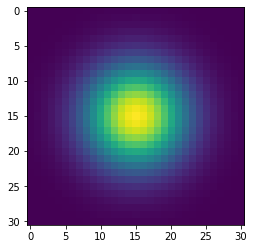

In [3]:
plt.imshow(gaussian_filter(5))

### 1.1.2 Generating an Octave

In [4]:
def get_octave(init_level, s=5, sigma=1.6):
    octave = [init_level]
    k = 2**(1/s)
    fil = gaussian_filter(k * sigma)

    # repeated convolutions with the same filter to produce an octave
    for i in range(s+2):
        next_level = convolve(octave[-1], fil)
        octave.append(next_level)
    return octave

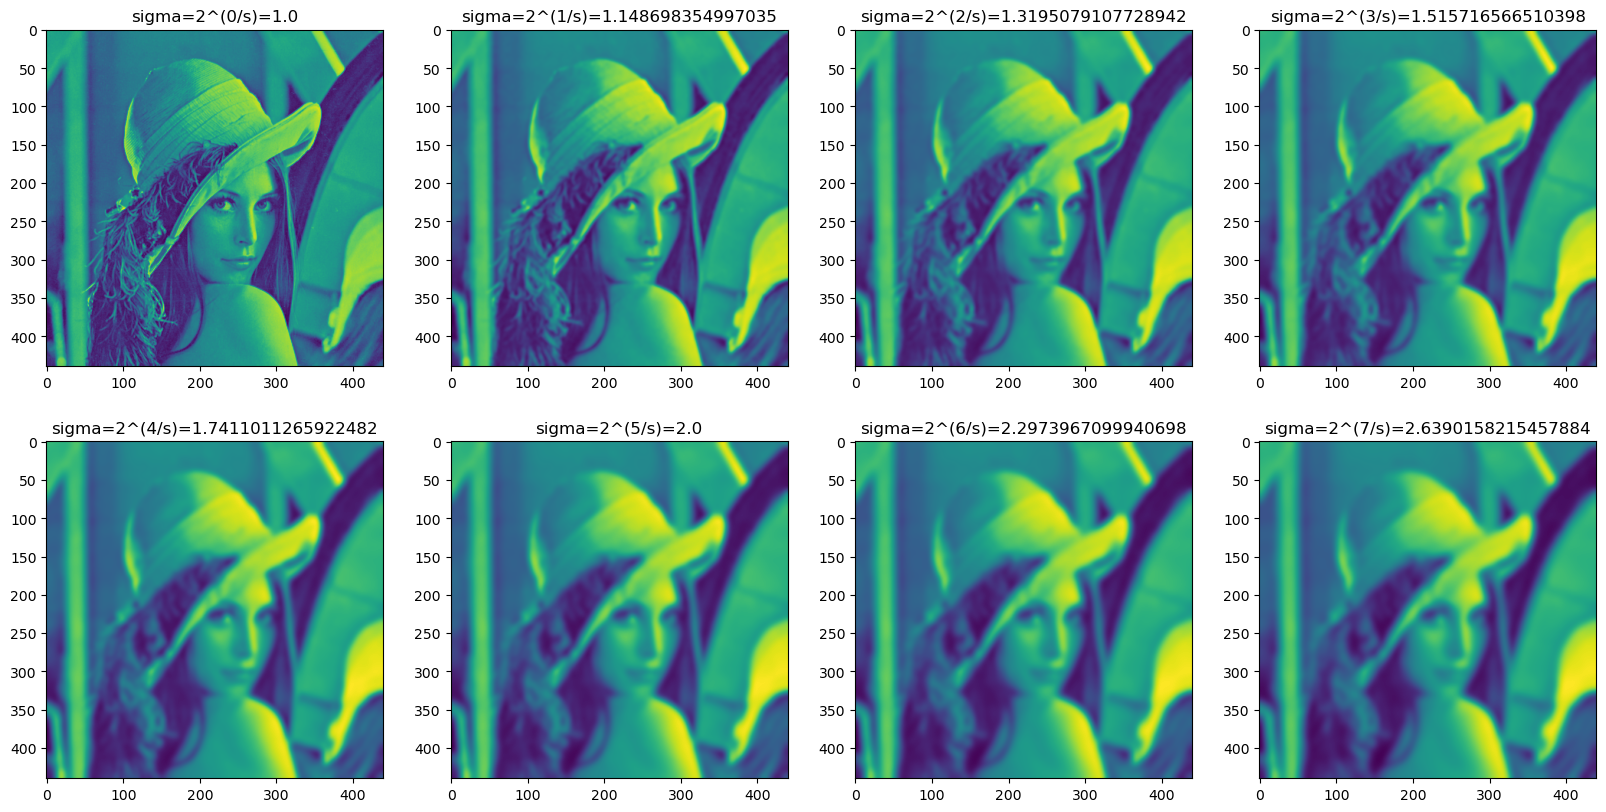

In [5]:
img = rgb2gray(imread('images/lenna.png'))
octave = get_octave(img)

h, w = 2, 4
fig, ax = plt.subplots(h, w, figsize=(w*5, h*5), dpi=100)
index=0
s = 5
for i in range(h):
    for j in range(w):
        ax[i, j].imshow(octave[index])
        ax[i, j].set_title("sigma=2^({0}/s)={1}".format(index, 2**((index)/s)))
        index+=1
plt.show()

### 1.1.3 Gaussian Pyramid of octaves

In [7]:
def get_gaussian_pyramid(img, num_octaves=4, s=5, sigma=1.6):
    pyramid = [] # array of octaves
    for i in range(num_octaves):
        octave = get_octave(img, s, sigma) # create octave
        pyramid.append(octave)
        img = octave[-3][::2, ::2] # sampling every second pixel
    return pyramid

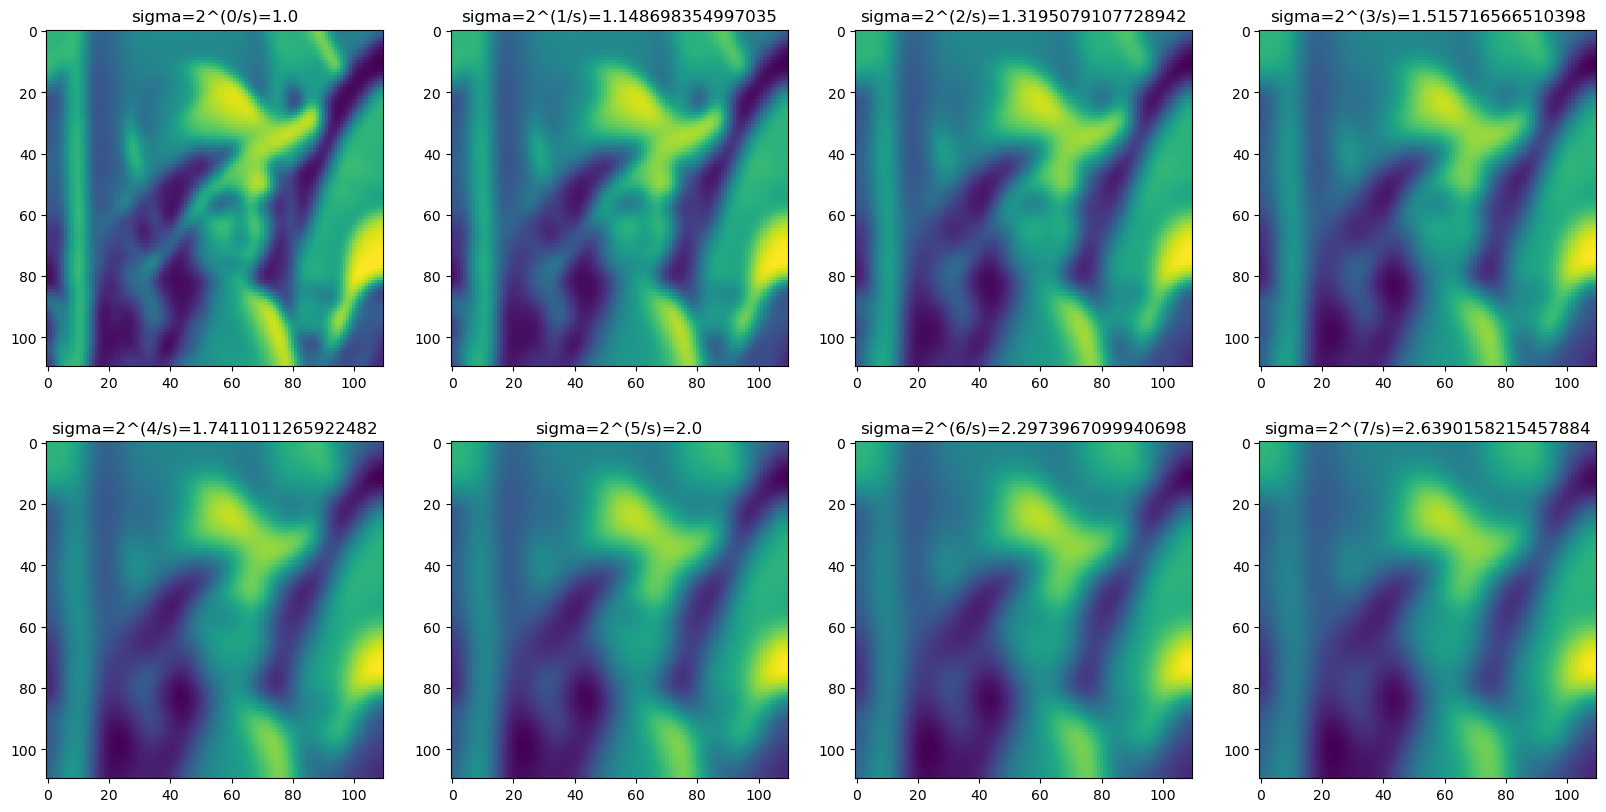

In [8]:
p = get_gaussian_pyramid(img)
octave = p[2]
h, w = 2, 4
fig, ax = plt.subplots(h, w, figsize=(w*5, h*5), dpi=100)
index=0
s = 5
for i in range(h):
    for j in range(w):
        ax[i, j].imshow(octave[index])
        ax[i, j].set_title("sigma=2^({0}/s)={1}".format(index, 2**((index)/s)))
        index+=1
plt.show()

### 1.1.4 Difference of Gaussian Octave (DoG)

In [9]:
def get_DoG_octave(gaussian_octave):
    octave = []
    for i in range(1, len(gaussian_octave)):
        octave.append(gaussian_octave[i] - gaussian_octave[i-1])
    return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2)

def get_DoG_pyramid(gaussian_pyramid):
    return [get_DoG_octave(octave) for octave in gaussian_pyramid]

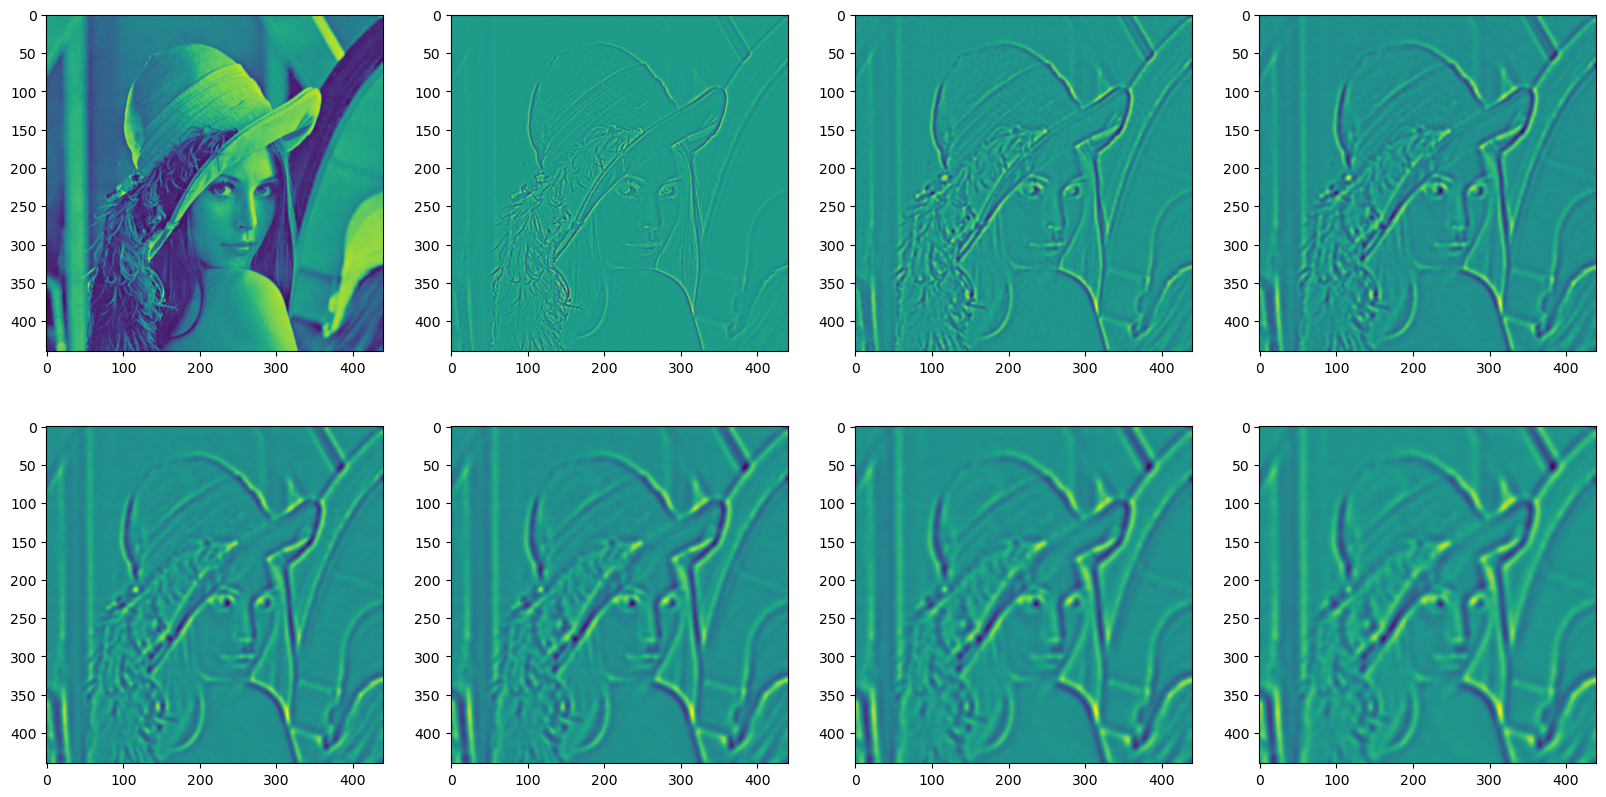

In [10]:
DoG_oct = get_DoG_octave(p[0])
h, w = 2, 4
fig, ax = plt.subplots(h, w, figsize=(w*5, h*5), dpi=100)
index=0
s = 5
for i in range(h):
    for j in range(w):
        if(index==0):
            ax[i, j].imshow(p[0][0])
            index+=1
            continue
        ax[i, j].imshow(DoG_oct[:, :, index-1])
        index+=1
plt.show()

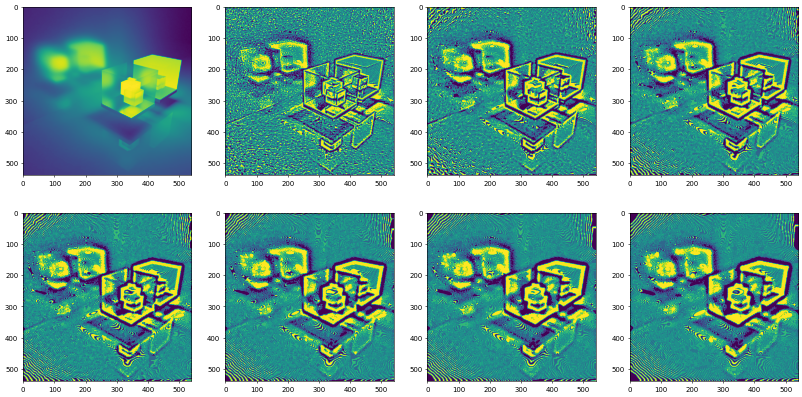

In [11]:
img = cv2.imread("./images/light_cubes_sm.png")[:, :, 0]
octave = get_octave(img, 5, 1.6)

DoG = get_DoG_octave(octave)

h, w = 2, 4
fig, axs = plt.subplots(h, w, figsize=(20, 10), dpi=50)
index = 0
for i in range(h):
    for j in range(w):
        if(index == 0): 
            axs[i, j].imshow(img)
            index += 1
            continue
        axs[i, j].imshow(DoG[:, :, index-1])
        index += 1
plt.show()

## 1.2 Keypoint Localization

In [24]:
def get_potential_keypoints(octave):
    keypoints = []

    octave[:,:,0] = 0
    octave[:,:,-1] = 0

    for i in range(1, octave.shape[0]-1):
        for j in range(1, octave.shape[1]-1):
            for k in range(1, octave.shape[2]-1):
                # Extracting the patch
                patch = octave[i-1:i+2, j-1:j+2, k-1:k+2]
                # Checking if the center pixel is the extrema
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    keypoints.append([i, j, k])

    return keypoints

def localize_keypoint(D, x, y, s):
    # calculating derivatives
    dx = (D[y,x+1,s]-D[y,x-1,s])/2.
    dy = (D[y+1,x,s]-D[y-1,x,s])/2.
    ds = (D[y,x,s+1]-D[y,x,s-1])/2.

    dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
    dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.
    dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.
    dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
    dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.
    dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]
    # Jacobian
    J = np.array([dx, dy, ds])
    # Hessian
    HD = np.array([
        [dxx, dxy, dxs],
        [dxy, dyy, dys],
        [dxs, dys, dss]])
    # Interpolating the offset
    offset = -LA.inv(HD).dot(J)
    return offset, J, HD[:2,:2], x, y, s

def find_keypoints_for_DoG_octave(D, R_thres, contrast_thres, w):
    # get potential keypoints for further filtering
    potential_kps = get_potential_keypoints(D)
    print('{0} potential keypoints found'.format(len(potential_kps)))

    keypoints = []
    for i, kp in enumerate(potential_kps):
        try:
            y, x, s = kp[0], kp[1], kp[2]
            # calculate offset
            offset, J, H, x, y, s = localize_keypoint(D, x, y, s)
            # calculate contrast
            contrast = D[y,x,s] + 0.5*J.dot(offset)
            if abs(contrast) < contrast_thres: 
                continue
            # using Hessian to eliminate edges
            trace_H = np.trace(H)
            det_H = LA.det(H)
            if(det_H == 0): 
                continue

            R = (trace_H**2)/det_H
            if R > R_thres: 
                continue

            interpolated_kp = np.array([x, y, s]) + offset

            # throw out boundary points because I don't want to deal with them
            if interpolated_kp[1] >= D.shape[0] or interpolated_kp[0] >= D.shape[1]: 
                continue 

            keypoints.append(kp)
        except:
            pass

    print('{0} keypoints found remain after filtering'.format(len(keypoints)))
    return np.array(keypoints)

def get_keypoints(DoG_pyramid, R_thres, contrast_thres, w):
    return [find_keypoints_for_DoG_octave(D, R_thres, contrast_thres, w) for D in DoG_pyramid]

## 1.3 Orientation Assignment

In [13]:
def get_gradients(L, x, y):
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    # magnitude
    m = np.sqrt(dx**2 + dy**2)
    # orientation
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta

def bin_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

def fit_parabola(hist, bin_num, bin_width):
    # epsilon
    eps = 1e-6
    
    # calculating orientation (center value) of the current bin
    center_bin_val = bin_num*bin_width + bin_width/2.

    # calculating orientation of right bin
    if bin_num == len(hist)-1: 
        # if right bin is the last bin
        right_bin_val = 360 + bin_width/2
    else: 
        right_bin_val = (bin_num+1)*bin_width + bin_width/2.

    # calculating orientation of the left bin
    if bin_num == 0: 
        # if left bin is the first bin
        left_bin_val = -bin_width/2.
    else: 
        left_bin_val = (bin_num-1)*bin_width + bin_width/2.
    
    # Solving for coefficients of the parabola: ax^2 + bx + c = 0
    A = np.array([
        [center_bin_val**2, center_bin_val, 1],
        [right_bin_val**2, right_bin_val, 1],
        [left_bin_val**2, left_bin_val, 1]])
    b = np.array([
        hist[bin_num],
        hist[(bin_num+1)%len(hist)], 
        hist[(bin_num-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    # x = [a, b, c]. x coordinate of axis is given by (-b)/2a
    return -x[1]/(2*(x[0]+eps))

def assign_orientation(kps, octave, num_bins=36):
    
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:
        kp_x, kp_y, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        sigma = kp[2]*1.5
        w = int(2*np.ceil(sigma)+1)
        fil = gaussian_filter(sigma)

        L = octave[...,s]
        hist = np.zeros(num_bins, dtype=np.float32)
        '''
        Each sample added to the histogram is weighted by its 
        gradient magnitude and by a Gaussian-weighted circular window 
        with a sigma that is 1.5 times that of the scale of the keypoint.
        - SIFT paper
        '''
        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = kp_x+ox, kp_y+oy
                
                if x < 0 or x > octave.shape[1]-1: continue
                elif y < 0 or y > octave.shape[0]-1: continue
                
                m, theta = get_gradients(L, x, y)
                weight = fil[oy+w, ox+w] * m

                bin_ = bin_orientation(theta, num_bins)
                hist[bin_] += weight

        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])
        
        '''
        The highest peak in the histogram is detected, and then any 
        other local peak that is within 80% of the highest peak is 
        used to also create a keypoint with that orientation.
        - SIFT Paper
        '''
        max_val = np.max(hist)
        for bin_num, val in enumerate(hist):
            if bin_num == max_bin: 
                continue

            if 0.8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, bin_num, bin_width)])

    return np.array(new_kps)

## 1.4 Local Descriptor Creation

In [14]:
def get_histogram_for_subregion(m, theta, num_bins, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bins, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle-reference_angle) % 360
        bin_num = bin_orientation(angle, num_bins)
        vote = mag

        hist_interp_weight = 1 - abs(angle - (bin_num*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[bin_num] += vote

    return hist

def get_local_descriptors(kps, octave, w=16, num_bins=8, num_subregions=4):
    descs = []
    bin_width = 360//num_bins

    for kp in kps:
        kp_x, kp_y, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)
        '''
        A Gaussian weighting function with  equal to one half the width 
        of the descriptor window is used to assign a weight to the magnitude 
        of each sample point. - SIFT Paper
        
        gaussian_filter multiplies sigma by 3 implies 3*(w/6) = w/2
        '''
        fil = gaussian_filter(w/6) 
        L = octave[...,s]
        
        # getting the lower bounds of the patch
        t, l = max(0, kp_y-w//2), max(0, kp_x-w//2)
        # getting the upper bounds of the patch
        b, r = min(L.shape[0], kp_y+w//2+1), min(L.shape[1], kp_x+w//2+1)
        # slicing the patch from image at scale at which the keypoint is detected
        patch = L[t:b, l:r]
        if(patch.shape[0]< w+1 or patch.shape[1] < w+1):
            continue
        # get gradients for each pixel 
        dx = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)

        # magnitude
        m = np.sqrt(dx**2 + dy**2)
        # orientation
        theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
        
#         print("fil: {0}, dx: {1}, dy: {2}, patch: {3}".format(fil.shape, dx.shape, dy.shape, patch.shape))
#         print("(t, l): ({0}, {1})\n(b, r):({2}, {3})".format(t, l, b, r))
        
        dx, dy = dx*fil, dy*fil

        subregion_w = w//num_subregions
        featvec = np.zeros(num_bins * num_subregions**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                                theta[t:b, l:r].ravel(), 
                                                num_bins, 
                                                kp[3], 
                                                bin_width,
                                                subregion_w)
                featvec[i*subregion_w*num_bins + j*num_bins:i*subregion_w*num_bins + (j+1)*num_bins] = hist.flatten()

        featvec /= max(1e-6, LA.norm(featvec))
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, LA.norm(featvec))
        descs.append(featvec)

    return np.array(descs)

In [15]:
class SIFT(object):
    def __init__(self, img, s=5, num_octave=4, sigma=1.6, r_thres=10, contrast_thres=0.03, w=16):
        '''
        img: file path of the image
        s: number of images in an octave
        num_octave: Number of octaves
        sigma: initial sigma value to produce Gaussian filtered images
        r_thres: threshold on ratio of eigen values
        contrast_thres: contrast threshold for keypoint interpolation
        w: window size for feature descriptor
        '''
        self.im = rgb2gray(img)
        self.s = s
        self.sigma = sigma
        self.num_octave = num_octave
        self.contrast_thres = contrast_thres
        # converting ratio of eigen values threshold to threshold on Tr(H)^2/Det(H)
        self.R_thres = (r_thres+1)**2 / r_thres 
        self.w = w

    def get_features(self):
        # computing Gaussian pyramids
        gaussian_pyr = get_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
        # computing difference of Gaussian pyramids
        DoG_pyr = get_DoG_pyramid(gaussian_pyr)
        # localizing final keypoints
        kp_pyr = get_keypoints(DoG_pyr, self.R_thres, self.contrast_thres, self.w)
        feats = []

        for i, DoG_octave in enumerate(DoG_pyr):
            kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
            feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))

        self.kp_pyr = kp_pyr
        self.feats = feats

        return feats

In [36]:
# img = rgb2gray(imread("./images/light_cubes_sm.png"))
img = rgb2gray(imread('images/lenna.png'))

sift_detector = SIFT(img)
features = sift_detector.get_features()
kp_pyr = sift_detector.kp_pyr

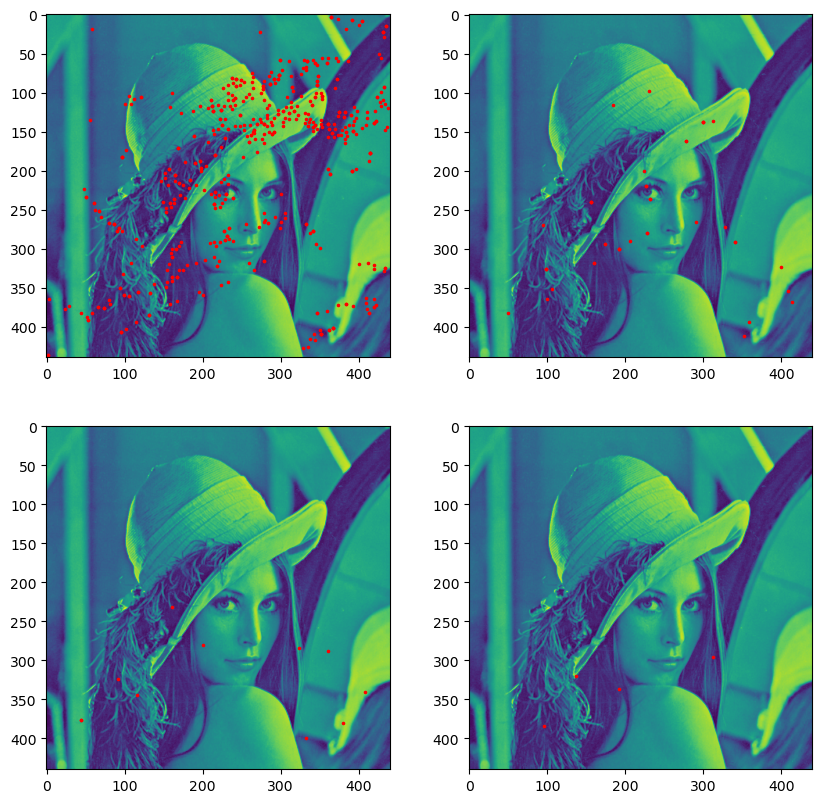

In [37]:
_, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
index = 0
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(img)
        scaled_kps = kp_pyr[index] * (2**index)
        ax[i, j].scatter(scaled_kps[:,0], scaled_kps[:,1], c='r', s=2.5)
        index+=1
plt.show()

4247 potential keypoints found
437 keypoints found remain after filtering
528 potential keypoints found
47 keypoints found remain after filtering
122 potential keypoints found
20 keypoints found remain after filtering
37 potential keypoints found
8 keypoints found remain after filtering


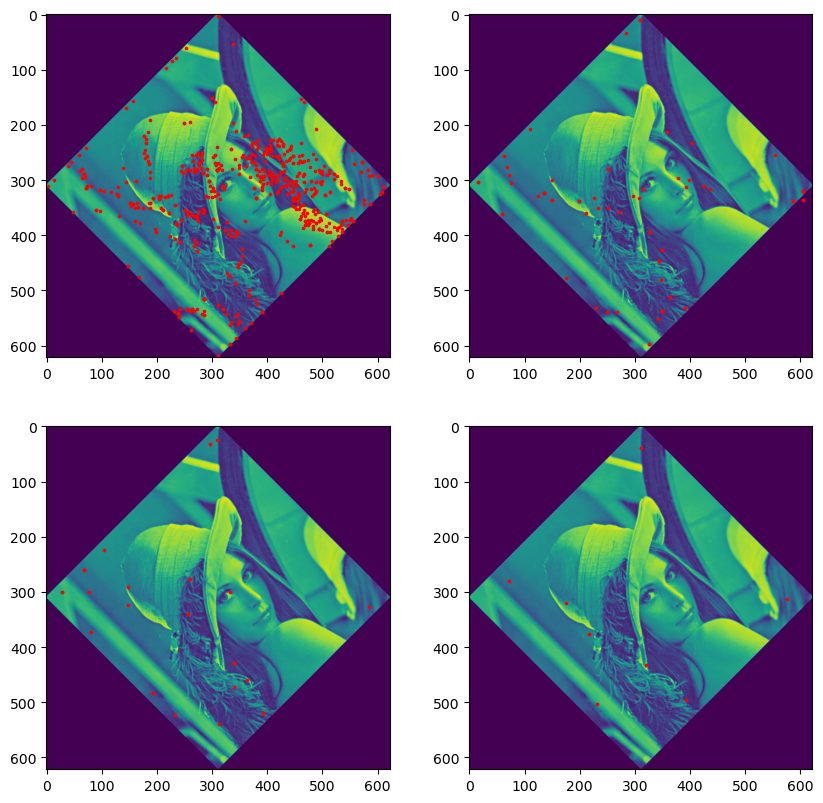

In [38]:
# img = rgb2gray(imread("./images/light_cubes_sm.png"))
img = rgb2gray(imread('images/lenna_rotated.png'))

sift_detector = SIFT(img)
features = sift_detector.get_features()
kp_pyr = sift_detector.kp_pyr


_, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
index = 0
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(img)
        scaled_kps = kp_pyr[index] * (2**index)
        ax[i, j].scatter(scaled_kps[:,0], scaled_kps[:,1], c='r', s=2.5)
        index+=1
plt.show()

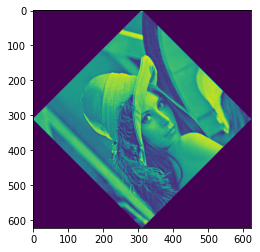

In [21]:
plt.imshow(cv2.imread('images/lenna_rotated.png',0))

https://arxiv.org/pdf/1608.01807.pdf

https://github.com/vbalnt/tfeat/blob/master/tfeat-test.ipynb

In [30]:
img1 = cv2.imread('images/lenna.png',0) 
img2 = cv2.imread('images/lenna_rotated.png',0)

sift1 = SIFT(img1)
sift2 = SIFT(img2)

des1, kp1 = sift1.get_features(), sift1.kp_pyr
des2, kp2 = sift2.get_features(), sift2.kp_pyr


5029 potential keypoints found


/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in ubyte_scalars


4402 keypoints found remain after filtering
1307 potential keypoints found
1164 keypoints found remain after filtering
328 potential keypoints found
294 keypoints found remain after filtering
73 potential keypoints found
66 keypoints found remain after filtering


/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  


5302 potential keypoints found
4736 keypoints found remain after filtering
1582 potential keypoints found
1433 keypoints found remain after filtering
497 potential keypoints found
458 keypoints found remain after filtering
143 potential keypoints found
125 keypoints found remain after filtering


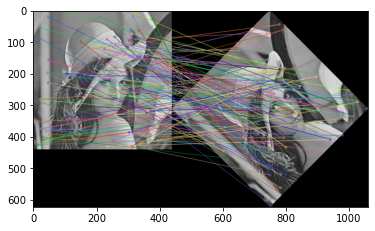

In [31]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1[0],des2[0], k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])

kp1_kp = [cv2.KeyPoint(kp1[0][i, 0], kp1[0][i, 1], kp1[0][i, 2]) for i in range(kp1[0].shape[0])]
kp2_kp = [cv2.KeyPoint(kp2[0][i, 0], kp2[0][i, 1], kp2[0][i, 2]) for i in range(kp2[0].shape[0])]

img3 = cv2.drawMatchesKnn(img1,kp1_kp,img2,kp2_kp,good,0, flags=2)
plt.imshow(img3)
plt.show()

## SIFT Feature Matching

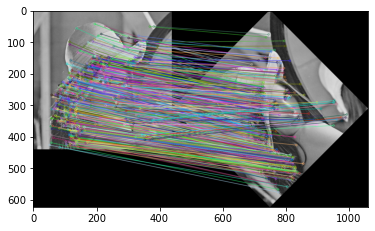

In [32]:
img1 = cv2.imread('images/lenna.png',0) 
img2 = cv2.imread('images/lenna_rotated.png',0)

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1_cv, des1_cv = sift.detectAndCompute(img1,None)
kp2_cv, des2_cv = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1_cv,des2_cv,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1_cv,img2,kp2_cv,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

## TFeat Feature Matching

In [33]:
import torchvision as tv
import tfeat_master.phototour as phototour
import torch
from tqdm import tqdm 
import numpy as np
import torch.nn as nn
import math 
import tfeat_master.tfeat_model as tfeat_model
import tfeat_master.tfeat_utils as tfeat_utils
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os

#init tfeat and load the trained weights
tfeat = tfeat_model.TNet()
models_path = './tfeat_master/pretrained-models'
net_name = 'tfeat-liberty'
tfeat.load_state_dict(torch.load(os.path.join(models_path,net_name+".params"), map_location=torch.device('cpu')))
tfeat.cpu()
tfeat.eval()

TNet(
  (features): Sequential(
    (0): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
    (5): Tanh()
  )
  (descr): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): Tanh()
  )
)

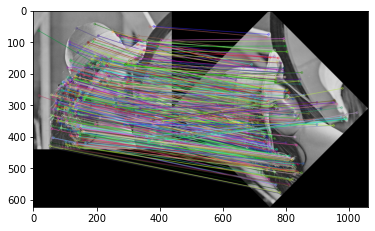

(<matplotlib.image.AxesImage at 0x7facaea67f98>, None)

In [40]:
# mag_factor is how many times the original keypoint scale
# is enlarged to generate a patch from a keypoint

mag_factor = 3
desc_tfeat1 = tfeat_utils.describe_opencv(tfeat, img1, kp1_cv, 32,mag_factor, False)
desc_tfeat2 = tfeat_utils.describe_opencv(tfeat, img2, kp2_cv, 32,mag_factor, False)

bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(desc_tfeat1,desc_tfeat2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])
        
img3 = cv2.drawMatchesKnn(img1,kp1_cv,img2,kp2_cv,good,0, flags=2)

plt.imshow(img3),plt.show()